In [1]:
# Bioinformatics
import pysam
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# General
import sys
import os
import re

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300

In [2]:
conditions_colors = {
    "30H": (0.0,0.0,1.0,0.8), # blue
    "30H_del": (0.0,0.7,1.0,0.25), # turquoise
    "30D": (1.0,0.5,0.0,0.8), # orangered
    "30D_del": (1.0,0.75,0.0,0.25), # orange
    "0Gy": (0.5,0.5,0.5,0.8), # dark grey
    "0Gy_del": (0.7,0.7,0.7,0.25), # lighter grey
    "100Gy": (0.7,0.0,0.6,0.8), # purple
    "100Gy_del": (1.0,0.0,0.8,0.25), # pinkish
    "250Gy": (0.0,0.75,0.0,0.8), # darkgreen
    "250Gy_del": (0.0,1.0,0.0,0.25), # limegreen
    "500Gy": (1.0,0.0,0.0,0.8), # red
    "500Gy_del": (1.0,0.5,0.5,0.25), # pink
    "H": (0.0,0.0,1.0,0.8),
    "H_del": (0.0,0.7,1.0,0.25),
    "D": (1.0,0.25,0.0,0.8),
    "D_del": (1.0,0.75,0.0,0.25),
}

conditions_cmap = {
    "30H":plt.cm.Blues,
    "30D":plt.cm.Oranges,
    "0Gy":plt.cm.Greys,
    "100Gy":plt.cm.Purples,
    "250Gy":plt.cm.Greens,
    "500Gy":plt.cm.Reds,
    "H":plt.cm.Blues,
    "D":plt.cm.Oranges,
}

conditions_names = {
    "30H": "GR Hydrated",
    "30D": "GR Desiccated",
    "0Gy": "GR 0Gy IR",
    "100Gy": "GR 100Gy IR",
    "250Gy": "GR 250Gy IR",
    "500Gy": "GR 500Gy IR",
    "H": "MA Hydrated",
    "D": "MA Desiccated"
}

conditions_shape = {
    "30H": "o",
    "30D": "o",
    "0Gy": "o",
    "100Gy": "o",
    "250Gy": "o",
    "500Gy": "o",
    "H": "d",
    "D": "d"
}

# COVERAGE
average_coverage = {
    "ancestor":   291.1,
    "P500_C18_E3":250.6,
}

col_MA = (55/255, 126/255, 184/255)
col_ARC = (255/255, 127/255, 0/255)
col_TE = (152/255, 78/255, 163/255, 0.65)

# LENGTHS OF CHROMOSOMES
reference = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa"
fai = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

# TELOMERES
telomeres = {
    "Chrom_1":([0,1500000], [11000000, 18146847]),
    "Chrom_2":([0,2000000], [15000000, 16274841]),
    "Chrom_3":([0,4000000], [13500000, 20354777]),
    "Chrom_4":([0,1000000], [14000000, 15224634]),
    "Chrom_5":([0,5000000], [15500000, 16930519]),
    "Chrom_6":([0,2000000], [12000000, 13893210]),
}

# POSITIONS OF GENES, CDS AND REPEATS 
genes = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.genes.bed"
cds = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.CDS.bed"
repeats = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/avaga.TEannotation.26-02-20.defragmentedDraftAnnot.bed"

# REPEATS DATAFRAME
reps = {"CHR":[], "START":[], "END":[]}
for line in open(repeats, "r") :
    s = line.strip().split("\t")
    reps["CHR"].append(s[0])
    reps["START"].append(int(s[1]))
    reps["END"].append(int(s[2]))
    
repdf = pd.DataFrame().from_dict(reps)

In [3]:
average_coverage = {
    "ancestor": 291.10,
    "H5A2": 50.79,
    "H5A2_50G": 58.62,
    "H5C2": 132.13,
}

In [4]:
ccycle = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

colors = {
    "DEL":ccycle[3], # Heterozygous deletion
    "DUP":ccycle[2], # Duplication
    "LOH":ccycle[9], # LOH
    "RES":ccycle[8], # Restoration (cov = 1 previously 0.5)
    "HDE":ccycle[5], # Homozygous deletion
    "ancestor":ccycle[0],
    "midpoint":ccycle[2],
    "endpoint":ccycle[1], # and "offspring" for ARC
    "nanopore":ccycle[3],
}

In [8]:
cov_anc = pd.read_csv(
    "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [9]:
cov_data = pd.read_csv(
    "/mnt/urbe2/disk3/Antoine/27-10-21_VariantCalling_MA/coverage/H5A2.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_data = cov_data.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [10]:
cov_data_50g = pd.read_csv(
    "/mnt/urbe2/disk3/Antoine/27-10-21_VariantCalling_MA/coverage/H5A2_50G.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_data_50g = cov_data_50g.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [11]:
cov_ctl = pd.read_csv(
    "/mnt/urbe2/disk3/Antoine/27-10-21_VariantCalling_MA/coverage/H5C2.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ctl = cov_ctl.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [13]:
def parse_region_illu_only(input_illumina, ancestor, sample, chrom, start, end) :
    
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(input_illumina)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for rec in vcf_in.fetch(chrom, start, end) :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    return df_illu

In [7]:
vcf_ME = "/mnt/urbe2/disk3/Antoine/27-10-21_VariantCalling_MA/genotype_allsamples/merged.only_het.gets.bcf"

In [14]:
df_data = parse_region_illu_only(vcf_ME, "ancestor", "H5A2", "Chrom_1", start=2900000, end=3100000)
df_data = pd.merge(df_data, cov_anc, on=["CHROM", "POS"], how="inner")
df_data = pd.merge(df_data, cov_data, on=["CHROM", "POS"], how="inner")

In [15]:
df_data_50g = parse_region_illu_only(vcf_ME, "ancestor", "H5A2_50G", "Chrom_1", start=2900000, end=3100000)
df_data_50g = pd.merge(df_data_50g, cov_anc, on=["CHROM", "POS"], how="inner")
df_data_50g = pd.merge(df_data_50g, cov_data_50g, on=["CHROM", "POS"], how="inner")

In [16]:
df_ctl = parse_region_illu_only(vcf_ME, "ancestor", "H5C2", "Chrom_1", start=2900000, end=3100000)
df_ctl = pd.merge(df_ctl, cov_anc, on=["CHROM", "POS"], how="inner")
df_ctl = pd.merge(df_ctl, cov_ctl, on=["CHROM", "POS"], how="inner")

In [19]:
def get_LOH_score(anc_AF, off_AF) :
    #delta = anc_AF["AF", "mean"] - off_AF["AF", "mean"]
    delta = anc_AF - off_AF
    return 2*abs(delta) # 1.0 = LOH, 0.0 = no changes

def get_COV_score(anc_COV, off_COV) :
    return off_COV - anc_COV

def plot(df_data, df_data_50g, df_ctl, start, end, sm1, sm2, ticklabelsize=6, labelsize=8, legendsize=6,) :
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(4,3))

    # Data
    flt_1 = df_data.query("POS > @start & POS < @end & QUAL >= 1000")
    flt_1 = flt_1.dropna()
    
    # Data 50G
    flt_m = df_data_50g.query("POS > @start & POS < @end & QUAL >= 1000")
    flt_m = flt_m.dropna()
    
    # Control
    flt_2 = df_ctl.query("POS > @start & POS < @end & QUAL >= 1000")
    flt_2 = flt_2.dropna()

    # Prepare data
    AAF = flt_1["AAF"].rolling(window=10).mean()
    AF_1 = flt_1["IAF"].rolling(window=10).mean()
    AF_2 = flt_2["IAF"].rolling(window=10).mean()
    AF_m = flt_m["IAF"].rolling(window=10).mean()
    
    LOH_score_1 = [get_LOH_score(x, y) for x, y in zip(AAF, AF_1)]
    LOH_score_2 = [get_LOH_score(x, y) for x, y in zip(AAF, AF_2)]
    LOH_score_m = [get_LOH_score(x, y) for x, y in zip(AAF, AF_m)]
    
    # Plot data
    ax = axs[0]
    ax.plot(flt_1["POS"], LOH_score_1, color=colors["endpoint"], lw=1.0, zorder=5, label=sm1)
    ax.plot(flt_m["POS"], LOH_score_m, color=colors["midpoint"], lw=1.0, zorder=3, label="{} (midpoint)".format(sm1))
    ax.plot(flt_2["POS"], LOH_score_2, color=colors["ancestor"], lw=1.0, zorder=2, label="{} (control)".format(sm2))

    # Format plot
    xticks = np.arange(start, end+1, 1e4)
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels, fontsize=ticklabelsize)

    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("LOH Score", fontsize=labelsize)
    afticks = [0.0, 0.25,0.5,0.75,1.0]
    ax.set_yticks(afticks)
    
    ax.grid(axis='y', zorder=1, lw=0.5, color=[0.5,0.5,0.5])
    ax.legend(loc="upper right", ncol=1, fontsize=legendsize, frameon=True,)

    # Coverage
    ax = axs[1]

    ADP = flt_1["COV_ANC"]/average_coverage["ancestor"]
    ADP_rol = ADP.rolling(window=75).median()

    DP_1 = flt_1["COV_ILU"]/average_coverage[sm1]
    DP_1_rol = DP_1.rolling(window=75).median()
    
    DP_m = flt_m["COV_ILU"]/average_coverage[sm1+"_50G"]
    DP_m_rol = DP_m.rolling(window=75).median()
    
    DP_2 = flt_2["COV_ILU"]/average_coverage[sm2]
    DP_2_rol = DP_2.rolling(window=75).median()
    
    COV_1 = [get_COV_score(x, y) for x, y in zip(ADP_rol, DP_1_rol)]
    COV_2 = [get_COV_score(x, y) for x, y in zip(ADP_rol, DP_2_rol)]
    COV_m = [get_COV_score(x, y) for x, y in zip(ADP_rol, DP_m_rol)]

    ax.plot(flt_1["POS"], COV_1, color=colors["ancestor"], lw=1.0, zorder=5, label=sm1)
    ax.plot(flt_m["POS"], COV_m, color=colors["midpoint"], lw=1.0, zorder=3, label="{} (midpoint)".format(sm1))
    ax.plot(flt_2["POS"], COV_2, color=colors["endpoint"], lw=1.0, zorder=2, label="{} (control)".format(sm2))

    ax.yaxis.grid(True, zorder=1)
    ax.set_ylim(-0.6, 0.6)
    ax.set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
    ax.tick_params(labelsize=ticklabelsize)
    ax.set_ylabel(r"$\Delta$ Coverage", fontsize=labelsize)

    start = min(flt_1["POS"])
    end = max(flt_1["POS"])
    ticks = np.linspace(start, end, 8)
    ticklabels = []
    for t in ticks :
        ticklabels.append("{:.3f}M".format(round(t/1000000, 3)))
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=ticklabelsize, rotation=90) #, fontsize=12)
    ax.set_xlabel("Zoom on Chromosome 1", fontsize=labelsize)

    #bs, be = 2650000, 4040000
    #byt = 0.33
    #ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
    #ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.1f}Mbps".format((be-bs)/1e6), ha="center", va="top")

    for ax in axs :
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', zorder=1, lw=0.5, color=[0.5,0.5,0.5])
        ax.tick_params(axis="y", length=0.5)
        ax.tick_params(labelsize=ticklabelsize)
        #ax.set_xlim(0, max(COV[contig]["POS", "first"])+1e4) #+1e5)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

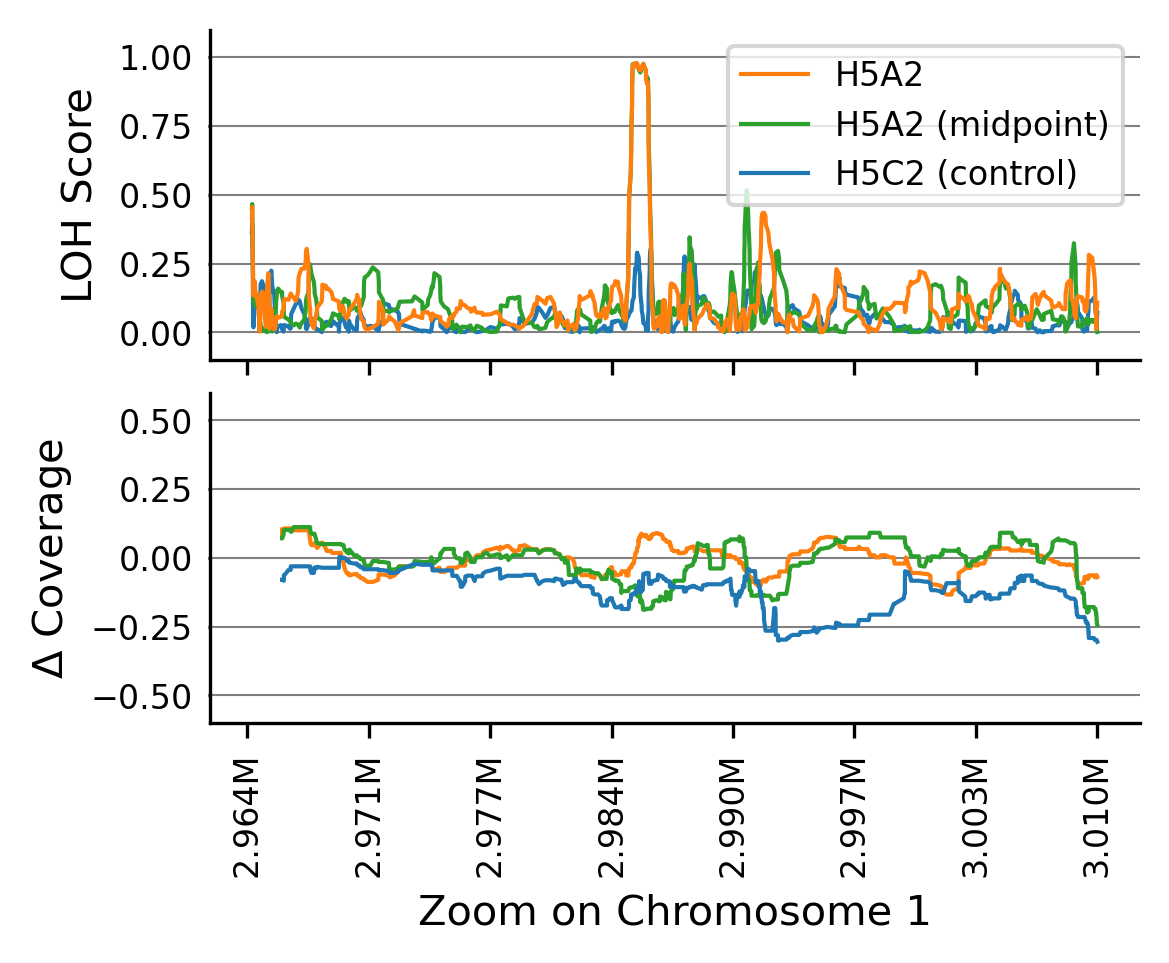

In [20]:
plot(df_data, df_data_50g, df_ctl, 2964000, 3010000, "H5A2", "H5C2", ticklabelsize=8, labelsize=10, legendsize=8) #12248015	12248287